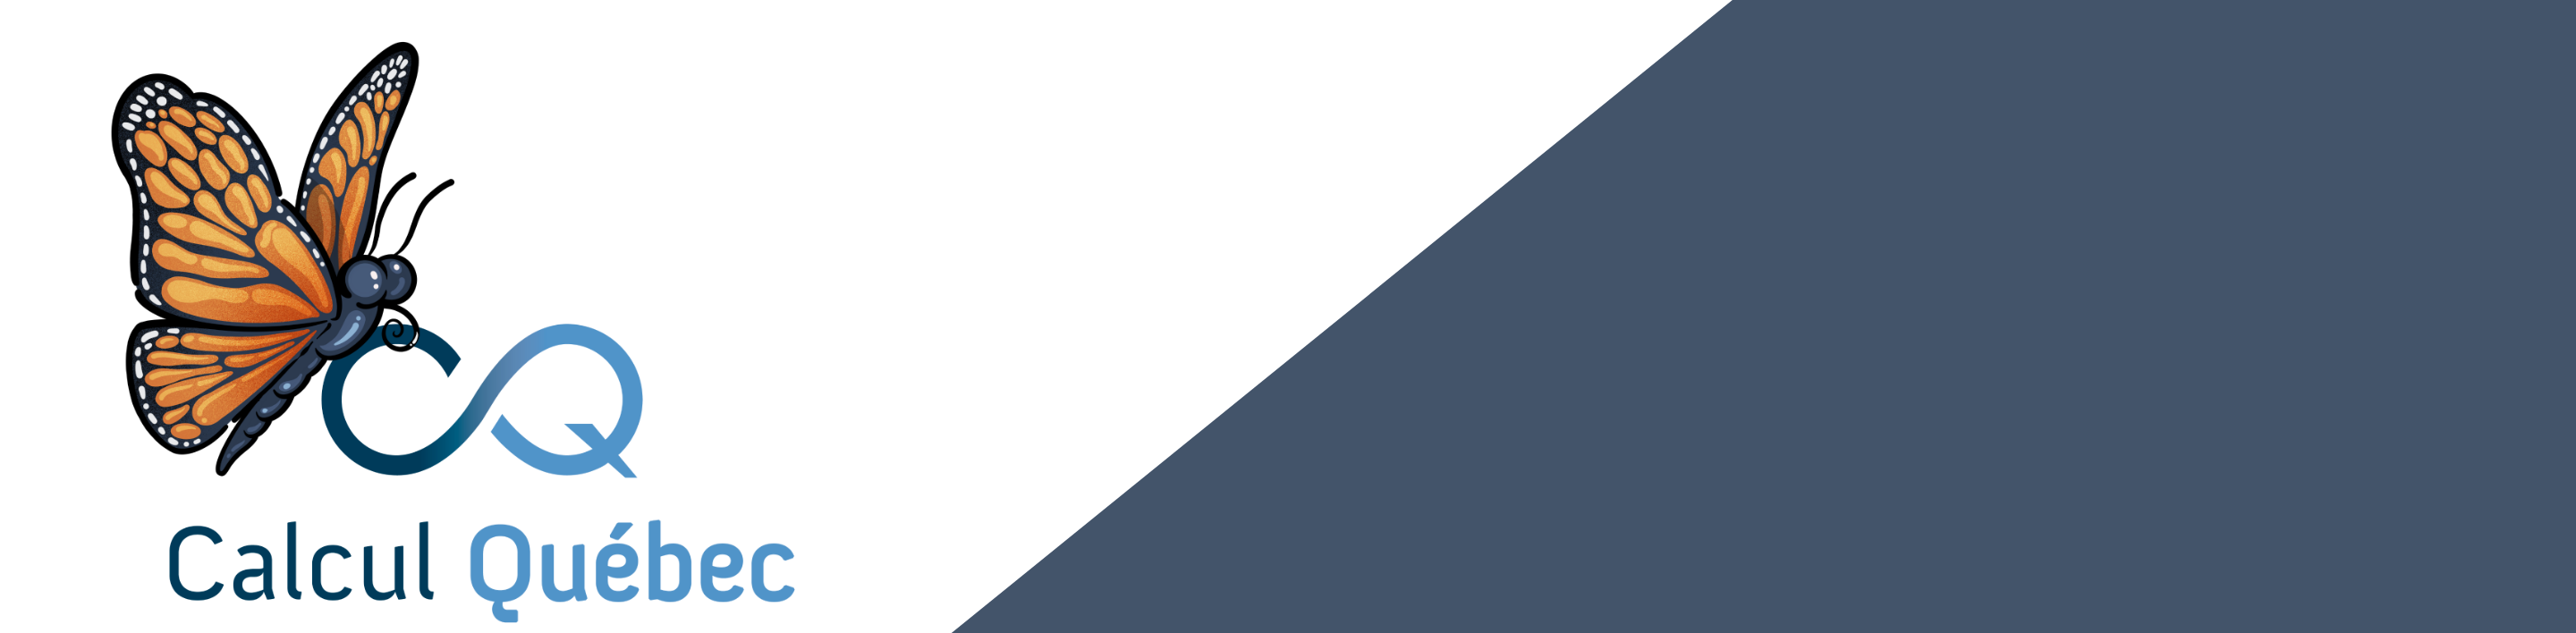

## Soumettre des tâches sur MonarQ


L'accès à MonarQ se fait depuis la grappe de calcul Narval. Pour plus d'informations voir [Premiers pas sur MonarQ](https://docs.alliancecan.ca/wiki/MonarQ#Premiers_pas_sur_MonarQ)

## 1. Plugin `pennylane-calculquebec` et MonarQ

Le plugin pennylane-calculquebec permet de développer des circuits quantiques en utilisant PennyLane et de les exécuter sur MonarQ. Il est aussi responsable de la transpilation du circuit en instructions (pulses) comprises par MonarQ.


In [5]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from autocorrecteur.correction_3_MonarQ import *

from pennylane_calculquebec.API.client import MonarqClient

my_client = MonarqClient("https://manager.anyonlabs.com", "your_user", "your_token", "your_projectID")

from pennylane_calculquebec.processing.config import MonarqDefaultConfig, NoPlaceNoRouteConfig, ProcessingConfig, PrintDefaultConfig, PrintNoPlaceNoRouteConfig
from pennylane_calculquebec.processing.steps import IBUReadoutMitigation, MatrixReadoutMitigation, PrintResults

    
my_config = PrintDefaultConfig("yukon") # config par défaut avec affichage des qubits et étapes de transpilation (placement et routage, decomposition des portes et optimisation du circuit)
my_config_no_routing = PrintNoPlaceNoRouteConfig(False)



Ici, on vient renseigner nos informations de connexion à travers le client et nous pouvons importer les configurations du transpileur que nous souhaitons. Voir [Transpileur quantique](https://docs.alliancecan.ca/wiki/Transpileur_quantique) et [Getting Started](https://github.com/calculquebec/pennylane-calculquebec/blob/main/doc/getting_started.ipynb).

## 2. Exemple - Circuit GHZ à 4 Qubits

Exécutons un état GHZ à quatre qubits. Cet état est défini comme suit
\begin{equation}
\vert \psi \rangle = \frac{1}{\sqrt{2}}(\vert 0000 \rangle + \vert 1111 \rangle).
\end{equation}
Quelle séquence de portes devez-vous appliquer pour créer cet état ?

Indice : Cet état est très similaire à l'état de Bell suivant $\vert \psi_{Bell} \rangle = \frac{1}{\sqrt{2}}(\vert 00 \rangle + \vert 11 \rangle)$. 
Assurez-vous de retourner une mesure qui peut être effectuée sur MonarQ (et non sur simulateur).

Vous pouvez laisser le transpileur choisir les qubits pour vous, ou vous pouvez les choisir manuellement en vous référant à l'architecture du QPU de MonarQ. 

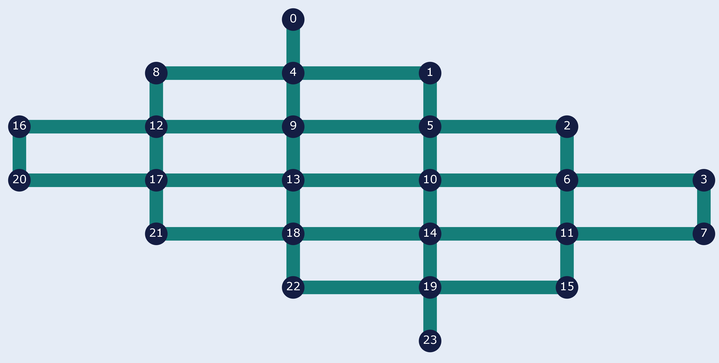

Rappel : il faut définir un `device`, un `qnode` et un circuit quantique.

In [7]:
dev = qml.device("monarq.backup", client = my_client, wires = 4, shots = 1000,  processing_config = my_config)

dev2 = qml.device("monarq.backup", client = my_client, wires = [2,3,4,5], shots = 1000, processing_config = my_config_no_routing)

In [13]:
# EXERCICE: Complétez les fonctions ghz() et ghz_manuel(). Dans la première on laisse le transpileur choisir les qubits et dans la seconde on choisit les qubits à utiliser
dev = qml.device("default.qubit", wires = 4)
@qml.qnode(dev)
def ghz():
    # à compléter
    qml.Hadamard(wires = 0)
    qml.CNOT(wires = [0,1])
    qml.CNOT(wires = [1,2])
    qml.CNOT(wires = [2,3])
    return qml.state()


#def ghz_manuel():
   ## à compléter



In [14]:
#@qml.qnode(dev2)
@qml.qnode(dev)
def ghz_on_monarq():
    ghz()
    #ghz_manuel()
    return qml.counts(wires = [0,1,2,3])  
    #return qml.counts(wires = [2,3,4,5])  
    
result = ghz_on_monarq()
print(result)

bitstr = list(result.keys())
values = list(result.values())


fig, ax = plt.subplots(figsize=(12, 6))
width = 0.5
ax.bar(bitstr, values, width, color='blue', alpha=0.6, label='Counts')
ax.legend()
plt.tight_layout()
plt.show()


DeviceError: Measurement CountsMP(wires=[0, 1, 2, 3], all_outcomes=False) not accepted for analytic simulation on default.qubit.

## 3. Simulation

Comparons les résultats avec le simulateur de PennyLane `default.qubit`.

In [10]:
dev_pennylane = qml.device("default.qubit", wires = 4, shots =1000)
@qml.qnode(dev_pennylane)
def ghz_simulated():
    ghz()
    return qml.counts()

result = ghz_simulated()
correction_exercice1(result)

bitstr = list(result.keys())
values = list(result.values())

#probs = [x / 1000 for x in values]

fig, ax  = qml.draw_mpl(ghz_simulated)()

fig, ax = plt.subplots(figsize=(12, 6))
width = 0.2
ax.bar(bitstr, values, width, color='blue', alpha=0.6, label='Counts')
ax.legend()
plt.tight_layout()
plt.show()

WireError: Cannot run circuit(s) on default.qubit as they contain wires not found on the device: {1, 2, 3}

## 4. Mitigation d'erreur

On a donc pu constater que les ordinateurs actuels dans l'ère NISQ font des erreurs. Ces dernières proviennent principalement d'imperfections matérielles que ce soit au niveau de l'application des portes, d'erreur de lecture, ou de décohérence des qubits. La mitigation d'erreur consiste donc à réduire l'impact de ces erreurs dans nos calculs quantiques.


Des stratégies de mitigation d'erreur ont été implémentées et intégrées au transpileur. Il s'agit contrairement à de la correction d'erreur, de techniques de post-processing sur les résultats mesurés. 

On retrouve entre autres:
* **Readout Measurement Mitigation**: correction des erreurs liés à la mesure (readout). 
* **Iterative Bayesian Unfolding (IBU)**: technique itérative pour retrouver une distribution plus précise des résultats.
* **Zero Noise Extrapolation (ZNE)**: on exécute le circuit en amplifiant le bruit afin d'estimer le résultat idéal par extrapolation.
* **Digital Dynamical Decoupling (DDD)**: implémentation d'une séquence de portes identités appliquée aux qubits inactifs pendant l'exécution d'un circuit afin de limiter les effets de décohérence.

Les deux dernières stratégies sont en cours de développement et s'appuient sur la toolbox [Mitiq](https://github.com/unitaryfund/mitiq). 

In [ ]:
my_config.steps.append(MatrixReadoutMitigation("yukon"))
my_config.steps.append(PrintResults())
my_config.steps.append(IBUReadoutMitigation("yukon"))

In [ ]:
@qml.qnode(dev)
def ghz_mitigated():
    ghz()
    return qml.counts(wires = [0,1,2,3])   

result = ghz_mitigated()
print(result)

bitstr = list(result.keys())
values = list(result.values())


fig, ax = plt.subplots(figsize=(12, 6))
width = 0.5
ax.bar(bitstr, values, width, color='blue', alpha=0.6, label='Counts')
ax.legend()
plt.tight_layout()
plt.show()